## 1. 데이터셋 로딩 및 전처리

### 1-1. 데이터셋 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
train = pd.read_csv('fog_train.csv', index_col=0).rename(columns=lambda x: x.split('.')[1])
test = pd.read_csv('fog_test.csv', index_col=0).rename(columns=lambda x: x.split('.')[1])

### 1-2. 데이터셋 분포 확인

In [92]:
# 클래스별 비율 확인
np.round(
    train['class'].value_counts(normalize=True).to_frame().reset_index().sort_values('index').set_index('index') * 100
, 3).astype(str) + '%'

,class
index,
-99,0.713%
1,0.249%
2,0.383%
3,0.386%
4,98.269%


In [93]:
np.round(
    train['class'].replace(-99, np.nan).replace(-99.9, np.nan)\
    .value_counts(normalize=True).to_frame().reset_index().sort_values('index').set_index('index') * 100
, 3).astype(str) + '%'

,class
index,
1.0,0.251%
2.0,0.386%
3.0,0.389%
4.0,98.975%


In [94]:
np.round(
    train['class'].replace(-99, np.nan).replace(-99.9, np.nan)\
    .value_counts().to_frame().reset_index().sort_values('index').set_index('index')
, 3)

,class
index,
1.0,7866
2.0,12088
3.0,12180
4.0,3101809


### 1-3. 전처리

In [3]:
# 지역 처리
train['stn_group'] = train['stn_id'].str[0]
train['stn_group_binary'] = train['stn_group'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5})

test['stn_group'] = test['stn_id'].str[0]
test['stn_group_binary'] = test['stn_group'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5})

In [4]:
# 안 쓰는 컬럼 drop
drop_columns = ['year', 'month', 'day', 'time', 'minute'] + ['stn_id', 'stn_group']

# train에서 class가 -99인 데이터(결측치) drop
train['class'] = train['class'].replace(-99, np.nan).replace(-99.9, np.nan) - 1

train_drop = train.dropna().drop(drop_columns, axis=1).drop('vis1', axis=1).reset_index(drop=True)
test_drop = test.drop(drop_columns, axis=1).drop('class', axis=1).reset_index(drop=True)

train_drop.shape, test_drop.shape

((3133943, 9), (262800, 9))

### 1-4. 과소표집

```imbalanced-learn``` 모듈을 이용하면 좋다.

1. **랜덤 과소표집 (Random Under-Sampling)**:
   - 가장 기본적인 방법으로, 다수 클래스의 샘플을 무작위로 선택하여 소수 클래스의 샘플 수와 같거나 비슷하게 맞춥니다.
   - 장점: 구현이 간단하고 빠름.
   - 단점: 중요한 정보를 잃을 가능성이 있음.


2. **클러스터 중심 과소표집 (Cluster Centroids)**:
   - K-means 클러스터링을 사용하여 다수 클래스 샘플을 몇 개의 클러스터로 묶은 다음, 각 클러스터의 중심을 대표 샘플로 사용합니다.
   - 장점: 데이터의 구조를 고려하여 샘플 수를 줄임.
   - 단점: 클러스터링의 결과에 따라 성능이 달라질 수 있음.


3. **토메크 링크 (Tomek Links)**:
   - 서로 다른 클래스에 속하는 샘플 쌍(토메크 링크)을 찾아 제거하여 클래스 간의 경계를 더 명확히 함.
   - 장점: 데이터의 경계를 명확히 하여 모델의 성능을 향상시킬 수 있음.
   - 단점: 처리 속도가 상대적으로 느릴 수 있음.


4. **편향된 무작위 과소표집 (NearMiss)**:
   - 다수 클래스 샘플 중 소수 클래스 샘플과 가장 가까운 샘플을 선택하거나, 소수 클래스 샘플과의 평균 거리가 가까운 샘플을 선택하는 방식.
   - 여러 가지 변형이 있으며, 데이터의 특성에 맞게 선택할 수 있음.
   - 장점: 중요한 샘플을 유지할 가능성이 높음.
   - 단점: 설정과 튜닝이 필요함.


5. **Condensed Nearest Neighbor (CNN)**:
   - KNN(K-Nearest Neighbor) 알고리즘을 사용하여 다수 클래스 샘플 중에서 필수적인 샘플만 남기고 나머지를 제거함.
   - 장점: 모델의 성능을 향상시킬 수 있는 중요한 샘플만 유지.
   - 단점: 연산 비용이 높을 수 있음.


6. **Edited Nearest Neighbor (ENN)**:
   - KNN 알고리즘을 사용하여 잘못 분류된 샘플을 제거함으로써 데이터의 품질을 높임.
   - 장점: 데이터의 노이즈를 줄여 모델의 성능을 향상시킬 수 있음.
   - 단점: 과소표집 과정에서 데이터 손실이 발생할 수 있음.

In [17]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

X = train_drop.drop('class', axis=1)
y = train_drop['class']

start_time = datetime.now()
rus = RandomUnderSampler(random_state=42)
X_res_rus, y_res_rus = rus.fit_resample(X, y)
time_delta = datetime.now() - start_time
print(f'''[Random Under-Sampling] Resampled dataset shape: {Counter(y_res_rus)}, 학습 시간: {time_delta.seconds}.{time_delta.microseconds // 10000}s''')

[Random Under-Sampling] Resampled dataset shape: Counter({0.0: 7866, 1.0: 7866, 2.0: 7866, 3.0: 7866}), 학습 시간: 0.54s


### 1-5. 데이터셋 분리

In [18]:
X_test = test_drop

X_train, X_val, y_train, y_val = train_test_split(X_res_rus, y_res_rus, random_state=42, train_size=0.75, stratify=y_res_rus)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((23598, 8), (7866, 8), (23598,), (7866,))

---

## 2. 모델링

### 2-1. 베이스라인 모델 생성

In [19]:
from sklearn.metrics import make_scorer

def grid_csi_index(y_true, y_pred):
    
    model_cm = confusion_matrix(y_true, y_pred)

    H = (model_cm[0][0] + model_cm[1][1] + model_cm[2][2])
    F = (model_cm[0][1] + model_cm[0][2] + 
            model_cm[1][0] + model_cm[1][2] + 
            model_cm[2][0] + model_cm[2][1] +
            model_cm[3][0] + model_cm[3][1] + model_cm[3][2])
    M = (model_cm[0][3] + model_cm[1][3] + model_cm[2][3])

    model_csi = H / (H + F + M)

    return model_csi

custom_scorer = make_scorer(grid_csi_index)

In [22]:
models = {
    'XGBoost': XGBClassifier(tree_method='hist', device='cuda', random_state=42),
    'LightGBM': LGBMClassifier(verbosity=-1, device='gpu', random_state=42)
}

model_results = {}
confusion_matrixes = {}
importance = {}

for name, model in models.items():
    start_time = datetime.now()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    csi = grid_csi_index(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')
    model_results[name] = csi
    confusion_matrixes[name] = confusion_matrix(y_val, y_pred)
#     if name == 'XGBoost':
#         importance[name] = model.get_score(importance_type='weight')
#         continue
#     elif name == 'LightGBM':
#         importance[name] = model.feature_importance(importance_type='split')
    time_delta = datetime.now() - start_time
    with open(f'''{name}(튜닝X)_{start_time.strftime('%Y%m%d%H%M%S')}.pkl''', 'wb') as file:
        pickle.dump(model, file)
#     print(f"{name} 학습 완료! CSI: {np.round(csi, 5)}, Accuracy: {np.round(accuracy, 5)}, 학습 시간: {time_delta.seconds}.{time_delta.microseconds // 10000}s")
#     print(f"{name} 학습 완료! CSI: {np.round(csi, 5)}, 정확도: {np.round(accuracy, 5)}, F1: {np.round(f1, 5)}, 학습 시간: {time_delta.seconds}.{time_delta.microseconds // 10000}s")
    print(f"{name} 학습 완료! CSI: {np.round(csi, 5)}, Accuracy: {np.round(accuracy, 5)}, Recall: {np.round(recall, 5)}, Precision: {np.round(precision, 5)}, 학습 시간: {time_delta.seconds}.{time_delta.microseconds // 10000}s")

XGBoost 학습 완료! CSI: 0.54478, Accuracy: 0.63946, Recall: 0.63946, Precision: 0.6387, 학습 시간: 1.36s
LightGBM 학습 완료! CSI: 0.52847, Accuracy: 0.62738, Recall: 0.62738, Precision: 0.62698, 학습 시간: 3.94s


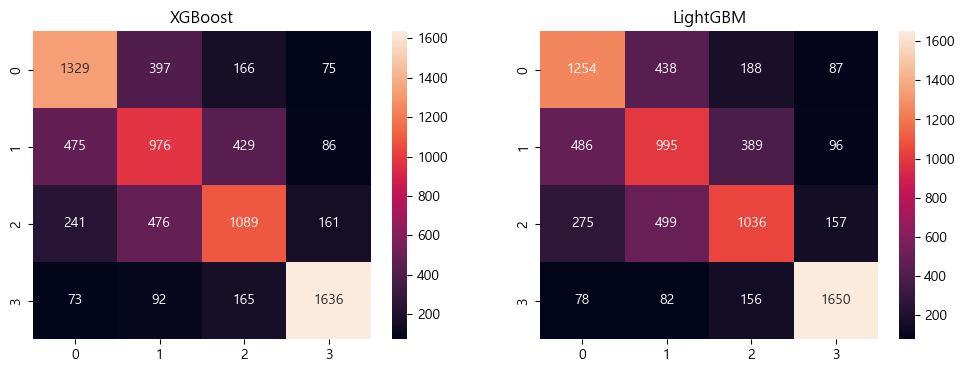

In [26]:
import seaborn as sns

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

sns.heatmap(
    pd.DataFrame(confusion_matrixes['XGBoost']),
    annot=True,
#     vmax=1000,
    fmt=".0f",
    ax=axes[0]
)
axes[0].set_title('XGBoost')

sns.heatmap(
    pd.DataFrame(confusion_matrixes['LightGBM']),
    annot=True,
#     vmax=1000,
    fmt=".0f",
    ax=axes[1]
)
axes[1].set_title('LightGBM')

plt.show()

성능에 큰 차이 없이 두 모델 모두 비슷하게 예측하는 점 확인 가능했다.

### 2-2. 하이퍼파라미터 튜닝

In [29]:
xgb = XGBClassifier(tree_method='hist', device='cuda', random_state=42)

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring=custom_scorer, cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters found: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Best cross-validation accuracy: 0.5492423328348598


In [30]:
best_model = grid_search.best_estimator_

In [32]:
with open(f'''XGBoost_{datetime.now().strftime('%Y%m%d%H%M%S')}.pkl''', 'wb') as file:
    pickle.dump(best_model, file)

### 2-3. 결과 확인

In [33]:
y_pred = best_model.predict(X_val)
csi = grid_csi_index(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"CSI: {np.round(csi, 5)}, Accuracy: {np.round(accuracy, 5)}, Recall: {np.round(recall, 5)}, Precision: {np.round(precision, 5)}")

CSI: 0.5605, Accuracy: 0.65319, Recall: 0.65319, Precision: 0.65311


In [36]:
y_pred = best_model.predict(X_test)
X_test['class'] = y_pred

In [40]:
np.round(
    X_test['class'].value_counts(normalize=True).to_frame().reset_index().sort_values('index').set_index('index') * 100
, 3).astype(str) + '%'

,class
index,
0,3.881%
1,6.755%
2,8.927%
3,80.438%
